# L-layer Neural Network Fully in Numpy
## weights are initialized with he-et initialization and applied Adam Algorithm

In [63]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL as Image
import math
from scipy.misc import imread, imresize




In [64]:
data_train = pd.read_csv("/home/pranav/Downloads/fashionmnist/fashion-mnist_train.csv")
Y_train = np.array(data_train['label'])
X_train = np.array(data_train.iloc[:,1:785])
data_test = pd.read_csv("/home/pranav/Downloads/fashionmnist/fashion-mnist_test.csv")
Y_test = np.array(data_test['label'])
X_test = np.array(data_test.iloc[:,1:785])
print (X_train.shape,Y_train.shape)





(60000, 784) (60000,)


(60000, 784)
(784,)


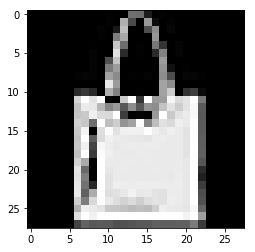

In [3]:
firstimage=X_train[65].reshape(28,28)
print (X_train.shape)
print (X_train[1].shape)
plt.imshow(firstimage,cmap="gray")

# print(X_train_pc[1])

In [65]:
def one_hot_encode(Y,classes):
    Y = np.eye(classes)[Y.reshape(-1)].T
    return Y
                
        

In [66]:
Xtrain = (X_train.T)/255
X = Xtrain
print (Xtrain.shape)
Ytrain = one_hot_encode(Y_train,classes=10)
Y = Ytrain
print (Ytrain.shape)


(784, 60000)
(10, 60000)


In [67]:

Xtest = (X_test.T)/255
Ytest = one_hot_encode(Y_test,10) 
print (Ytest.shape)
print (Xtest.shape)
XtrainpC = (X_train_pc.T)/255
YtrainpC = Y
print (XtrainpC.shape)

(10, 10000)
(784, 10000)
(256, 60000)


In [68]:
def sigmoid(Z):
    
    A = 1/(1+np.exp(-Z))
    cache = Z
    
    return A, cache

def relu(Z):
    A = np.maximum(0,Z)
    
    assert(A.shape == Z.shape)
    
    cache = Z 
    return A, cache


def relu_backward(dA, cache):
     
    Z = cache
    dZ = np.array(dA, copy=True) # just converting dz to a correct object.
    
    # When z <= 0, you should set dz to 0 as well. 
    dZ[Z <= 0] = 0
    
    assert (dZ.shape == Z.shape)
    
    return dZ

def sigmoid_backward(dA, cache):
    Z = cache
    
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    
    assert (dZ.shape == Z.shape)
    
    return dZ



In [81]:
# initializing the weights with he-et initialization
def initializer_weights(dim_layers):
    L=len(dim_layers)
    #initializing with he-et initialization
    #initializing the parameters 
    parameters={}
    for l in range(1,L):
        parameters["W"+str(l)] = np.random.randn(dim_layers[l],dim_layers[l-1])*np.sqrt(2./(dim_layers[l-1]))
        parameters["b"+str(l)] = np.zeros((dim_layers[l],1))
    return parameters
        
    

In [82]:
# calculating hypothesis with  W,b,A(A is the previous layer activation function)
def linear_forward(W,b,Aprev):
    Z=np.dot(W,Aprev)+b
    cache = W,b,Aprev
    
    return Z , cache

In [83]:
# activation is the forward propagation
def linear_activation_forward(W,b,A,activation):
    if activation=="relu":
        Z,L_cache = linear_forward(W,b,A)
        A,A_cache = relu(Z)
    elif activation == "sigmoid":
        Z,L_cache = linear_forward(W,b,A)
        A,A_cache = sigmoid(Z)
    cache = (L_cache,A_cache)
    return A,cache

In [84]:
# calculating forawrd propagation 
def L_layerfeedforward(parameters,X,Y):
    A_prev =  X
    L = len(parameters)//2 # L+1 = number of layers
    caches = []
    #cache contains Z 
    for l in range(1,L):
        A,cache = linear_activation_forward(parameters["W"+str(l)],parameters["b"+str(l)],A_prev,activation = "relu")
        caches.append(cache)
        A_prev = A

    Al,cache =  linear_activation_forward(parameters["W" + str(L)],parameters["b" + str(L)],A_prev,activation = "sigmoid")
    caches.append(cache)
    
    
    return Al,caches   

In [85]:
# error of the neural network 
def Loss(A,Y):
    m = A.shape[1]
    logval = (np.multiply(Y,np.log(A)) + np.multiply((1-Y),np.log(1-A)))
    loss =- (1/m)*np.sum(logval)
    return loss

In [74]:
# Calculating Backward activation derivatives
def Back_propactivation(dA,cache,activation):
    if activation == "relu":
        dZ = relu_backward(dA, cache)
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, cache)
    return dZ           

In [86]:
# Calculating derivatives of Weights 
def derivatives_weights(dZ,cache):
    W,b,Aprev = cache
    m = Aprev.shape[1]
    
    dW = (1./m)*np.dot(dZ,Aprev.T)
    db = (1./m)*np.sum(dZ,axis = 1,keepdims=True)
    dA = np.dot(W.T,dZ)
    
    return dW,db,dA
    

In [87]:
# Bcakward propagation 
def L_layerbackward(Al,cache,Y,dim_layer):
    
    # derivative of last layer activation with respect to loss
    dAl = -(np.divide(Y,Al) - np.divide((1-Y),(1-Al)))
    L= len(dim_layer) # L=5
    grads = {}
    #L_cache contains W,b,Aprev and A_cache contains Z
    lc=len(cache)
    L_cache,A_cache = cache[lc-1]
    a,b = cache[0]    
    dZ = Back_propactivation(dAl,A_cache,activation="sigmoid")
    grads["dW"+str(L-1)],grads["db"+str(L-1)],grads["dA"+str(L-2)] = derivatives_weights(dZ,L_cache)
    dAl = grads["dA"+str(L-2)]
    for l in reversed(range(1,lc)):
        L_cache,A_cache = cache[l-1]
        dZ = Back_propactivation(dAl,A_cache,activation="relu")
        grads["dW"+str(l)],grads["db"+str(l)],grads["dA"+str(l-1)] = derivatives_weights(dZ,L_cache)
        dAl = grads["dA"+str(l-1)]
        
    return grads    

In [88]:
# Adam parameters initialization 
def initializing_adam(parameters):
    v={}
    s={}
    L=len(parameters)//2 # length of the layers
    for l in range(L):
        v["dW"+str(l+1)] = np.zeros((parameters["W"+str(l+1)].shape))
        s["dW"+str(l+1)] = np.zeros((parameters["W"+str(l+1)].shape))
        v["db"+str(l+1)] = np.zeros((parameters["b"+str(l+1)].shape))
        s["db"+str(l+1)] = np.zeros((parameters["b"+str(l+1)].shape))
    return v,s

In [89]:
# Adam optimization  algorithm
def adam_algorithm(parameters,grads,beta1,beta2,epsilon,learning_rate,t):
    
    v,s = initializing_adam(parameters)
    V_corrected = {}
    S_corrected = {}
    
    L= len(parameters)//2
    for l in range(L):
        v["dW"+str(l+1)] = beta1*v["dW"+str(l+1)] + (1-beta1)*grads["dW"+str(l+1)]
        v["db"+str(l+1)] = beta1*v["db"+str(l+1)] + (1-beta1)*grads["db"+str(l+1)]
        
        V_corrected["dW"+str(l+1)] = v["dW"+str(l+1)]/(1-beta1**t)
        V_corrected["db"+str(l+1)] = v["db"+str(l+1)]/(1-beta1**t)
        
        s["dW"+str(l+1)] = beta2*s["dW"+str(l+1)] + (1-beta2)*np.square(grads["dW"+str(l+1)])
        s["db"+str(l+1)] = beta2*s["db"+str(l+1)] + (1-beta2)*np.square(grads["db"+str(l+1)])
        
        S_corrected["dW"+str(l)] = s["dW"+str(l+1)]/(1-beta2**t)
        S_corrected["db"+str(l)] = s["db"+str(l+1)]/(1-beta2**t)
        
        
        parameters["W"+str(l+1)] =  parameters["W"+str(l+1)] - learning_rate*V_corrected["dW"+str(l+1)]
        parameters["b"+str(l+1)] =  parameters["b"+str(l+1)] - learning_rate*V_corrected["db"+str(l+1)]
        
    return parameters
        
        

        


In [79]:
def random_minibatches(X,Y,batch_size,seeds):
    np.random.seed(seeds)
    m = X.shape[1]
    permutation = list(np.random.permutation(m))
    X_shuffled = X[:,permutation]
    Y_shuflled = Y[:,permutation].reshape(Y.shape[0],m)
    random_mini_batches = []
    
    num_batches = math.floor(m/batch_size)
    for random_batches in range(num_batches):
        X_random_mini = X_shuffled[:,random_batches*batch_size:(random_batches+1)*batch_size]
        Y_random_mini = Y_shuflled[:,random_batches*batch_size:(random_batches+1)*batch_size]
        mini_batch = (X_random_mini,Y_random_mini)
        random_mini_batches.append(mini_batch)
    if m%batch_size !=0:
        X_random_mini = X_shuffled[:,num_batches*batch_size:m]
        Y_random_mini = Y_shuflled[:,num_batches*batch_size:m]
        mini_batch = (X_random_mini,Y_random_mini)
        random_mini_batches.append(mini_batch)
    return random_mini_batches  

In [61]:
def L_layerneuralbetwork(dim_layer,learning_rate,beta1,beta2,epsilon,batch_size,num_iterations,X,Y,t):
    parameters = initializer_weights(dim_layer)
    seeds = 0
    costs =[]
    
    for i in range(num_iterations):
        random_batches = []
        m = X.shape[1]
        num_iteration_cost = 0
        number_minibatches = math.floor(m/batch_size)
        seeds = seeds+1
        random_batches = random_minibatches(X,Y,batch_size,seeds)
        for mini_batches in random_batches:
            (X_random_mini,Y_random_mini)  = mini_batches
            Al,cache = L_layerfeedforward(parameters,X_random_mini,Y_random_mini)
            cost = Loss(Al,Y_random_mini)
            num_iteration_cost += (cost/number_minibatches)
            grads = L_layerbackward(Al,cache,Y_random_mini,dim_layer)
            parameters = adam_algorithm(parameters,grads,beta1,beta2,epsilon,learning_rate,t)
            #         parameters = update_grads(parameters,grads,learning_rate) 
        if i%50==0:
            print (num_iteration_cost) 
        if i%25==0:
            costs.append(num_iteration_cost)
            plt.plot(np.squeeze(costs))
            plt.xlabel("loss per 25 itertions")
            plt.ylabel("loss")
            plt.title("loss of NN with number of iterations")
               
 
    return parameters

In [62]:
dim_layer=[784,400,100,30,20,10]
learning_rate = .00011
num_iterations = 1000
beta1 = 0.9
beta2 = 0.999
epsilon = 10**(-8)
t=2
batch_size = 32



4.37723512536082
1.1189743148112565
0.8970759899297069
0.8109010212922222
0.7602581265456286
0.7228998874097613
0.6924922352178886
0.6670273670848802
0.644854041912545
0.6253942736134077
0.6076727964300888
0.5915401560097674
0.5767379668075052
0.5627529552760484
0.5494660414240305
0.5367160525730337
0.52456986904955
0.5125555618777116
0.5009405364639719
0.48950204446437146


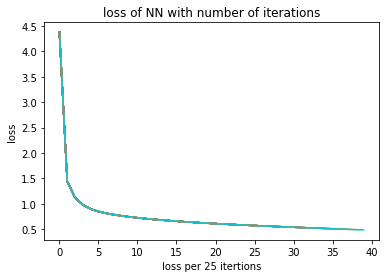

In [22]:
parameters = L_layerneuralbetwork(dim_layer,learning_rate,beta1,beta2,epsilon,batch_size,num_iterations,X,Y,t)


In [39]:
Zl,caches = L_layerfeedforward(parameters,X,Y)
print (Zl.shape)
pred = np.argmax(Zl,axis = 0)
print (pred.shape)
print (Y_train.shape)
print (Y_train)
Zl = pred.T
Y = Y_train.T
print (np.mean(Zl==Y))


(10, 60000)
(60000,)
(60000,)
[2 9 6 ... 8 8 7]
0.91065


In [43]:
Zt,cache = L_layerfeedforward(parameters,Xtest,Ytest)
pred = np.argmax(Zt,axis = 0)
testpred = pred.T
testY = Y_test.T
print (np.mean(testpred==testY))


0.8879


10
(60000, 784)
T-shirt/top


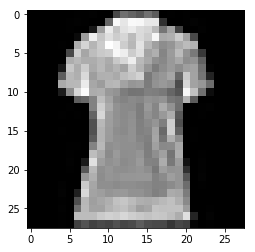

In [101]:
Types_Of_Cloths=["T-shirt/top","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankle boot"]
print (len(Types_Of_Cloths))
values_for_pred = int(np.random.randint(60000))
firstimage=X_train[values_for_pred].reshape(28,28)
print (X_train.shape)
plt.imshow(firstimage,cmap="gray")
print (Types_Of_Cloths[Y_train[values_for_pred]])


(10000, 784)
Coat


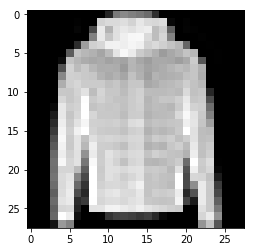

In [105]:
values_for_pred = int(np.random.randint(10000))
firstimage=X_test[values_for_pred].reshape(28,28)
print (X_test.shape)
plt.imshow(firstimage,cmap="gray")
print (Types_Of_Cloths[Y_test[values_for_pred]])
